# Question Answering

This model shows a simple form of question answering. The goal of this model is to build
a network that will output answers to questions based on supplied statements as
described in the book. You will bind two features (color and shape) by circular
convolution. Then you will provide a cue to the model to determine either one of the
features by deconvolution.

**Note**: Simplified method of building the model using the SPA (semantic pointer
architecture) package in Nengo 2.0  is shown in the last few sections of this notebook.

In [1]:
# Setup the environment
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import nengo
from nengo.spa import Vocabulary

## Create the model
This model has parameters as described in the book, with the ensembles having 300
neurons in 20 dimensions and the bind and unbind networks having 70 neurons per
dimension. The model relies on SPA (Semantic Pointer Architecture) methods for
charachterizing representation, transformation and control.

Depending on your computer, this model may run slowly which can be avoided by several
ways as discussed in the book. In order to run the model in direct mode (explained in
the book), the parameter 'neuron_type' should be set to nengo.Direct() while creating
the ensembles.

As mentioned in the book, the color input will alternate every 0.5 seconds between
**RED**
and **BLUE**. In the same way the shape input alternates between **CIRCLE** and
**SQUARE**.
Thus, the model will bind alternatingly **RED * CIRCLE** and **BLUE * SQUARE** for 0.5
seconds each. In parallel you will ask a question from the model by providing a cue
which will be used for deconvolving bound semantic pointers to determine an answer. For
example, when the cue is **CIRCLE** the model should respond with **RED**. The cue will
cycle
through **CIRCLE**, **RED**, **SQUARE**, and **BLUE** within one second.

In [2]:
dim = 20  # Number of dimensions
n_neurons = 300  # Number of neurons in population
n_conv = 70  # Number of neurons per dimension in bind/unbind populations

rng = np.random.RandomState(0)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)
model = nengo.Network(label="Question Answering", seed=7)

with model:
    # Ensembles
    ens_A = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="A")
    ens_B = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="B")
    ens_C = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="C")
    ens_D = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="D")
    ens_E = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="E")

    # Creating the bind network
    net_bind = nengo.networks.CircularConvolution(n_neurons=n_conv, dimensions=dim)
    nengo.Connection(ens_A, net_bind.A)
    nengo.Connection(ens_B, net_bind.B)
    nengo.Connection(net_bind.output, ens_D)

    # Creating the Unbind network
    net_unbind = nengo.networks.CircularConvolution(
        n_neurons=n_conv, dimensions=dim, invert_a=True
    )
    nengo.Connection(ens_C, net_unbind.A)
    nengo.Connection(ens_D, net_unbind.B)
    nengo.Connection(net_unbind.output, ens_E)

    # Getting semantic pointer values
    CIRCLE = vocab.parse("CIRCLE").v
    BLUE = vocab.parse("BLUE").v
    RED = vocab.parse("RED").v
    SQUARE = vocab.parse("SQUARE").v
    ZERO = [0] * dim

    # Function for providing color input
    def color_input(t):
        if (t // 0.5) % 2 == 0:
            return RED
        return BLUE

    # Function for providing shape input
    def shape_input(t):
        if (t // 0.5) % 2 == 0:
            return CIRCLE
        return SQUARE

    # Function for providing the cue
    def cue_input(t):
        sequence = [ZERO, CIRCLE, RED, ZERO, SQUARE, BLUE]
        idx = int((t // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Defining inputs
    input_A = nengo.Node(output=color_input, size_out=dim, label="Input A")
    input_B = nengo.Node(output=shape_input, size_out=dim, label="Input B")
    input_C = nengo.Node(output=cue_input, size_out=dim, label="Input C")

    # Connecting input to ensembles
    nengo.Connection(input_A, ens_A)
    nengo.Connection(input_B, ens_B)
    nengo.Connection(input_C, ens_C)

## Add Probes to Collect Data

Anything that is probed will collect the data it produces over time, allowing you to
analyze and visualize it later.

In [3]:
with model:
    A_probe = nengo.Probe(ens_A, synapse=0.03)
    B_probe = nengo.Probe(ens_B, synapse=0.03)
    C_probe = nengo.Probe(ens_C, synapse=0.03)
    D_probe = nengo.Probe(ens_D, synapse=0.03)
    E_probe = nengo.Probe(ens_E, synapse=0.03)

## Run the model

In order to run the model without nengo_gui, you have to create a Nengo simulator. Then,
you
can run that simulator over and over again without affecting the original model.

In [4]:
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(3.0)  # Run it for 3 seconds

## Plot the results

Text(0.5, 0, 'time [s]')

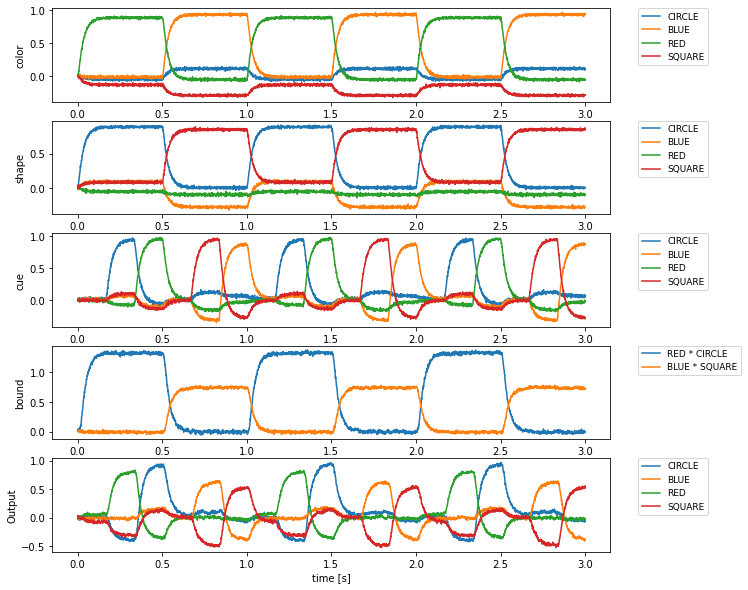

In [5]:
plt.figure(figsize=(10, 10))

plt.subplot(5, 1, 1)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[A_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("color")

plt.subplot(5, 1, 2)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[B_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("shape")

plt.subplot(5, 1, 3)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[C_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("cue")

plt.subplot(5, 1, 4)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[D_probe].T), label=pointer)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("bound")

plt.subplot(5, 1, 5)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[E_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("Output")
plt.xlabel("time [s]")

The last graph shows that the output is most similar to the semantic pointer bound to
the current cue. For example, when **RED** and **CIRCLE** are being bound and the cue is
**CIRCLE**, the output is most similar to **RED**.

## Create the model using the `nengo.spa` package

Now we will build this model again, using the `nengo.spa`
package built into Nengo 2.0. You will see that using the SPA package considerably
simplifies model construction and visualization through `nengo_gui`.

In [6]:
from nengo import spa

dim = 32  # The dimensionality of the vectors
rng = np.random.RandomState(4)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

# Adding semantic pointers to the vocabulary
CIRCLE = vocab.parse("CIRCLE")
BLUE = vocab.parse("BLUE")
RED = vocab.parse("RED")
SQUARE = vocab.parse("SQUARE")
ZERO = vocab.add("ZERO", [0] * dim)

# Create the spa.SPA network to which we can add SPA objects
model = spa.SPA(label="Question Answering", vocabs=[vocab])
with model:
    model.A = spa.State(dim)
    model.B = spa.State(dim)
    model.C = spa.State(dim)
    model.D = spa.State(dim)
    model.E = spa.State(dim)

    actions = spa.Actions(
        "D = A * B",
        "E = D * ~C",
    )

    model.cortical = spa.Cortical(actions)

    # Function for providing color input
    def color_input(t):
        if (t // 0.5) % 2 == 0:
            return "RED"
        return "BLUE"

    # Function for providing shape input
    def shape_input(t):
        if (t // 0.5) % 2 == 0:
            return "CIRCLE"
        return "SQUARE"

    # Function for providing the cue
    def cue_input(t):
        sequence = ["ZERO", "CIRCLE", "RED", "ZERO", "SQUARE", "BLUE"]
        idx = int((t // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Inputs
    model.input = spa.Input(A=color_input, B=shape_input, C=cue_input)

## Run the model in `nengo_gui`

In [ ]:
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch5-question.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs
as shown in the figure below.

Graphs `A`, `B`, `C` show the colour, shape and cue inputs respectively. Graph `E` shows
that the output is most similar to the semantic pointer bound to the current cue (showin
in `C`). For example, when **RED** and **CIRCLE** are being bound and the cue is
**CIRCLE**, the
output is most similar to **RED**.

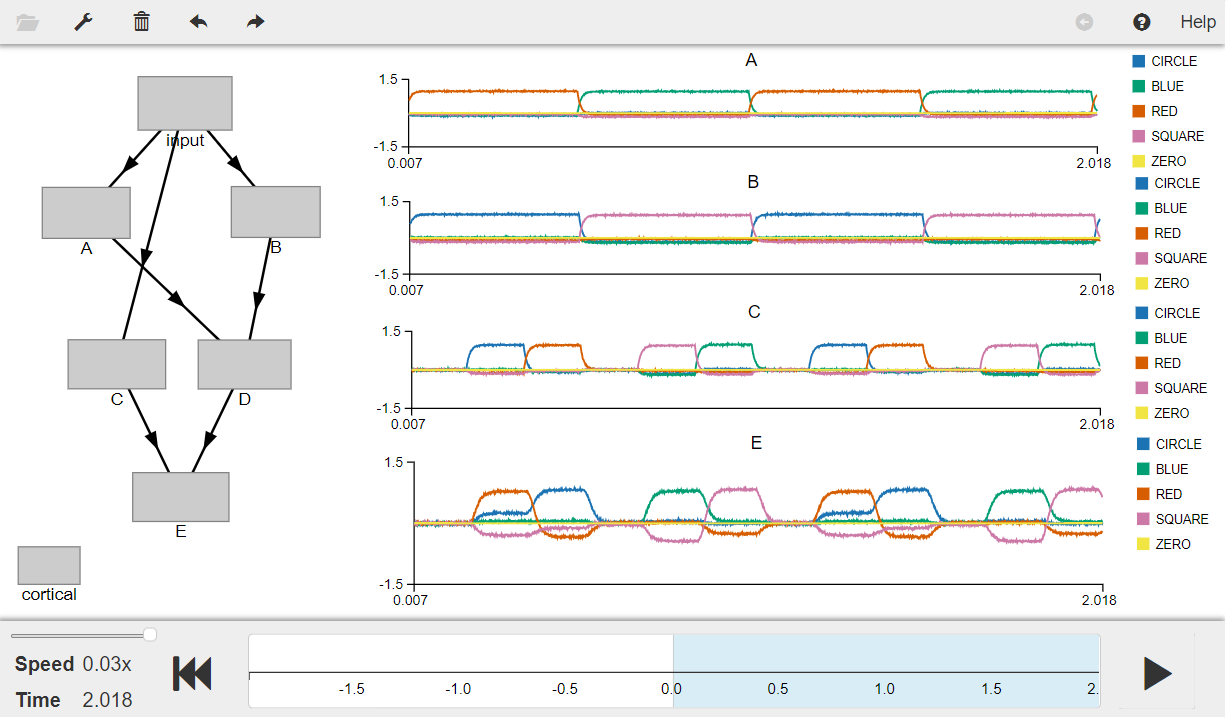

In [7]:
from IPython.display import Image

Image(filename="ch5-question.png")